In [1]:
# Parametersdata_path = '{PATH_TO_OUTS}'h5_name = '{PATH_TO_CATATAC_5_CRISPR9_H5SEURAT}'prj_name = "CATATAC_CATATAC_5_CRISPR9"protosp_path = '{PATH_TO_PROTOSPACERS_4SET_TSV}'

In [2]:
# data_path = '{PATH_TO_OUTS_2}'# h5_name = '{PATH_TO_CATATAC_4_CRISPR7}'# prj_name = "CATATAC_CATATAC_4_CRISPR7"# protosp_path = '{PATH_TO_PROTOSPACERS_4SET_TSV_2}'

In [3]:
library(Seurat)library(SeuratDisk)library(Signac)library(EnsDb.Hsapiens.v86)library(dplyr)library(ggplot2)library(bedr)library(Biostrings)library(SeuratPipe)library(scales)library(reshape2)library(Hmisc)library(tidyr)library(patchwork)library(readr)library(Biobase)#source('{PATH_TO_SCRUBLET_FUNCS_R}')

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.gr

In [4]:
set.seed(12345678)#setwd('{PATH_TO_SCRIPTS}')

In [5]:
min.cells.for.chrom.assay <- NULL

In [6]:
# the 10x hdf5 file contains both data types.# condition <- "cond6"# main_path <- "/home/vsevim/prj/catatac/analysis/Test3/"# data_path <- paste0(main_path, condition, '{PATH_TO_OUTS_3}')# h5_name   <- paste0(main_path, condition, '{PATH_TO_CONDITION_H5SEURAT}')# prj_name  <- paste0("CATATAC_", condition)# # data_path <- '{PATH_TO_OUTS_4}'# # h5_name    <- '{PATH_TO_CONDITION2_H5SEURAT}'# # prj_name  <- "CATATAC_Condition1"mx_path   <- paste0(data_path, "/filtered_feature_bc_matrix/")

In [7]:
mx_path

[1] "/home/jupyter-ayang/notebooks/cat-atac_pipeline/cond9/output/cellranger/outs/filtered_feature_bc_matrix/"

# Load 10x data

In [8]:
inputdata.10x <- Read10X(mx_path)

10X data contains more than one type and is being returned as a list containing matrices of each type.



In [9]:
# extract RNA and ATAC data
rna_counts  <- inputdata.10x$`Gene Expression`
atac_counts <- inputdata.10x$Peaks

## Create Seurat object

In [10]:
seurat <- CreateSeuratObject(counts = rna_counts, project = prj_name)

In [11]:
n_init_cell_count = length(Cells(seurat))
n_init_cell_count

[1] 8008

Get mitochondrial content

In [12]:
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat, pattern = "^MT-")

In [13]:
# Now add in the ATAC-seq data
# we'll only use peaks in standard chromosomes
grange.counts <- StringToGRanges(rownames(atac_counts), sep = c(":", "-"))
grange.use <- seqnames(grange.counts) %in% standardChromosomes(grange.counts)

In [14]:
atac_counts <- atac_counts[as.vector(grange.use), ]
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [15]:
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations)         <- "hg38"

Consider using the MACS2 peaks caller :https://satijalab.org/signac/articles/seurat_multiomic.html
"The set of peaks identified using Cellranger often merges distinct peaks that are close together.
This can create a problem for certain analyses, particularly motif enrichment analysis and
peak-to-gene linkage. To identify a more accurate set of peaks, we can call peaks using MACS2
with the CallPeaks() function. Here we call peaks on all cells together, but we could identify 
peaks for each group of cells separately by setting the group.by parameter, and this can help 
identify peaks specific to rare cell populations."

In [16]:
frag.file <- paste0(data_path, '{PATH_TO_ATAC_FRAGMENTS_GZ}')chrom_assay <- CreateChromatinAssay(   counts = atac_counts,   sep = c(":", "-"),   genome = 'hg38',   fragments = frag.file,   annotation = annotations )seurat[["ATAC"]] <- chrom_assay# removed min.cells = min.cells.for.chrom.assay

Computing hash



In [17]:
# add the gene information to the object
DefaultAssay(seurat) <- "ATAC"
Annotation(seurat) <- annotations
DefaultAssay(seurat) <- "RNA"

## QC

### Get RNA counts per cell

In [18]:
counts_per_cell <- Matrix::colSums(rna_counts)
cat("counts per cell: ", counts_per_cell[1:20], "\n") ## counts for first 5 cells

counts per cell:  9546 11406 48286 23017 10585 20265 10317 18015 43127 7700 5976 31272 11092 6534 1003 58286 9833 7685 7794 7499 


In [19]:
counts_per_gene <- Matrix::rowSums(rna_counts)
cat("counts per gene: ", counts_per_gene[1:20], "\n")  

counts per gene:  3 0 2 177 0 1 272 70 7 0 0 0 0 21 1513 6 1509 81 102 141 


In [20]:
genes_per_cell <- Matrix::colSums(rna_counts > 0) # count gene only if it has non-zero reads mapped.
cat("counts for non-zero genes: ", genes_per_cell[1:5])  ## counts for first 5 genes

counts for non-zero genes:  3927 4023 8758 6010 3919

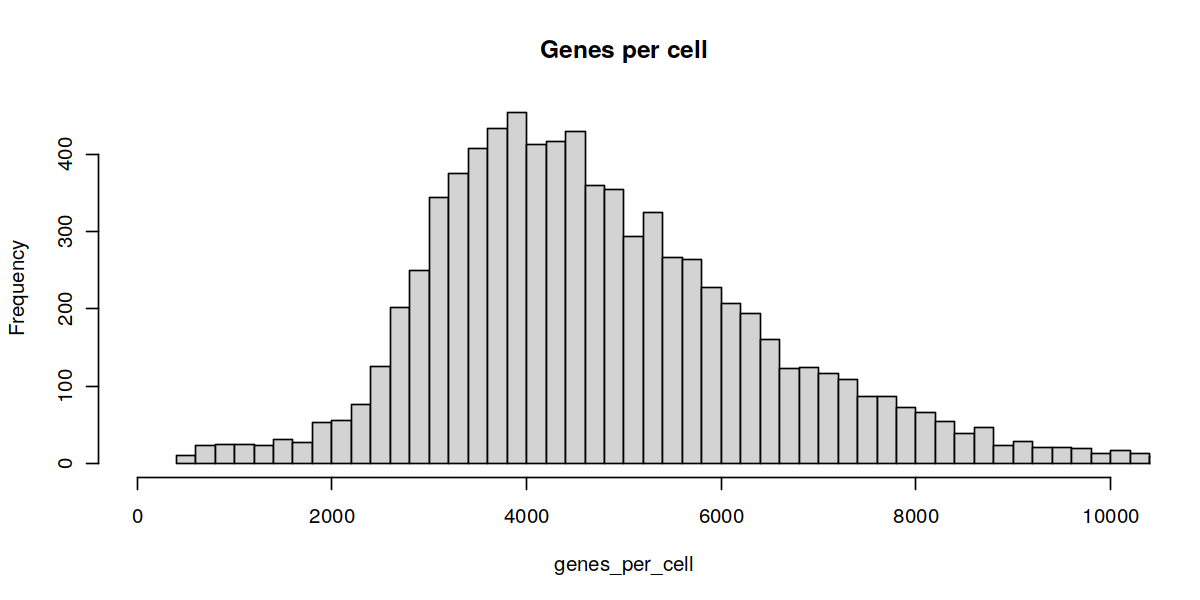

In [21]:
options(repr.plot.width=10, repr.plot.height=5)
#plot_log <- hist(log10(genes_per_cell), main="Genes per cell", breaks=100)
plot_lin <- hist(genes_per_cell, main="Genes per cell", breaks=100, xlim=c(1,10000))

### --

## ATAC counts per peak

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 162 rows containing missing values (`geom_bar()`)."


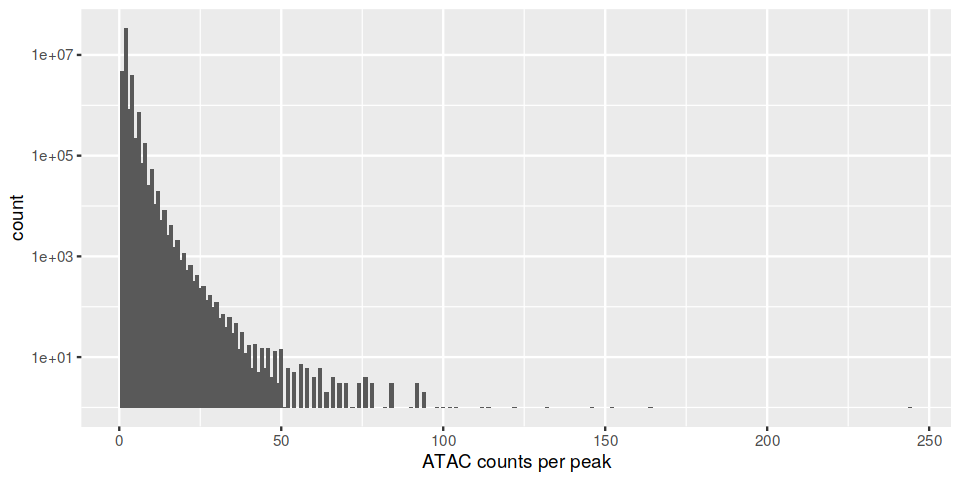

In [22]:
options(repr.plot.width=8, repr.plot.height=4)
x <- atac_counts@x
ggplot(data.frame(x), aes(x)) +
  geom_histogram(binwidth = 1) +
  scale_y_log10() +
  labs(x="ATAC counts per peak")

## Plot ATAC counts per cell 

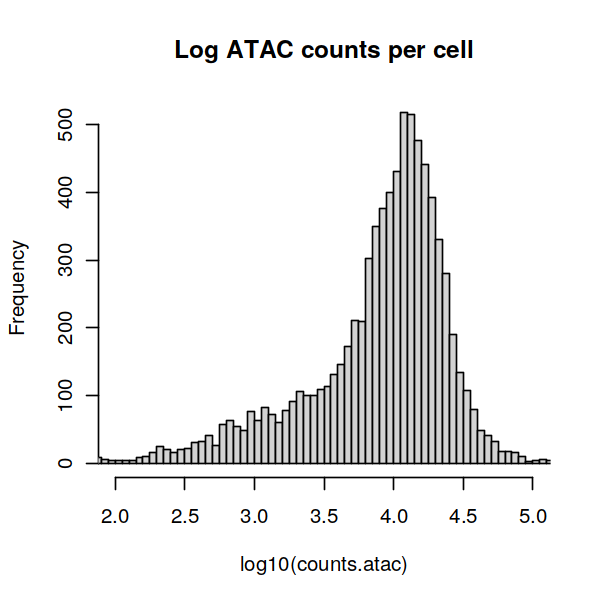

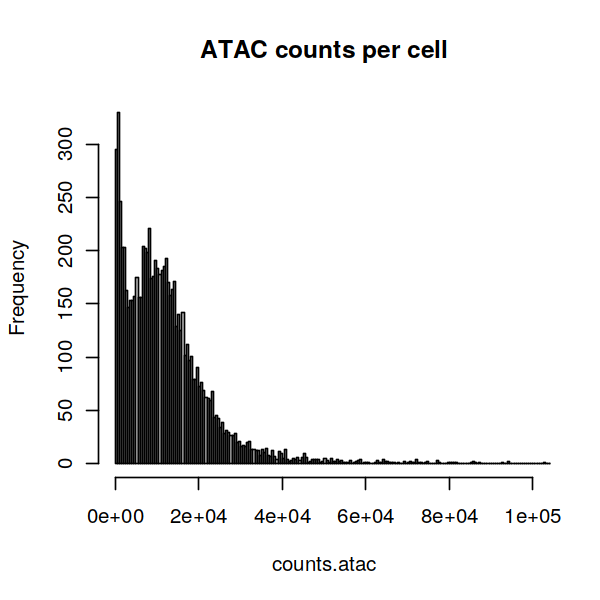

In [23]:
options(repr.plot.width=5, repr.plot.height=5)
#par(mfrow=c(1,2))
counts.atac <- seurat@meta.data$nCount_ATAC
plot_log    <- hist(log10(counts.atac), main="Log ATAC counts per cell", breaks=100, xlim=c(2,5))
plot_lin    <- hist(counts.atac, main="ATAC counts per cell", breaks=500, xlim=c(1,100000))

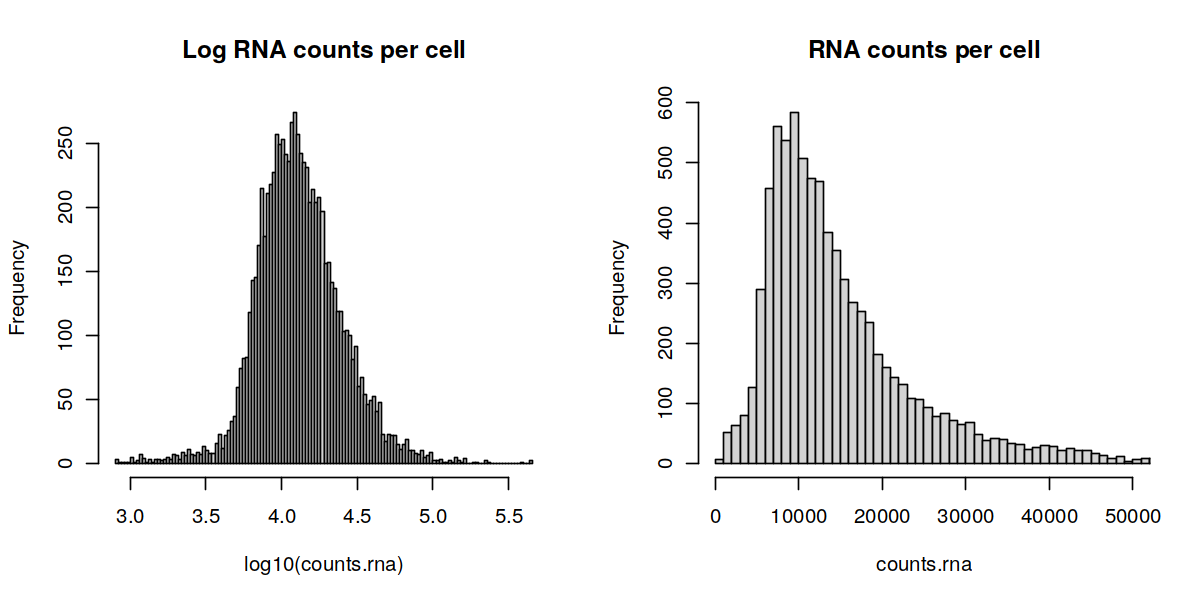

In [24]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
counts.rna <- seurat@meta.data$nCount_RNA
plot_log    <- hist(log10(counts.rna), main="Log RNA counts per cell", breaks=100)
plot_lin    <- hist(counts.rna, main="RNA counts per cell", breaks=500, xlim=c(1,50000))

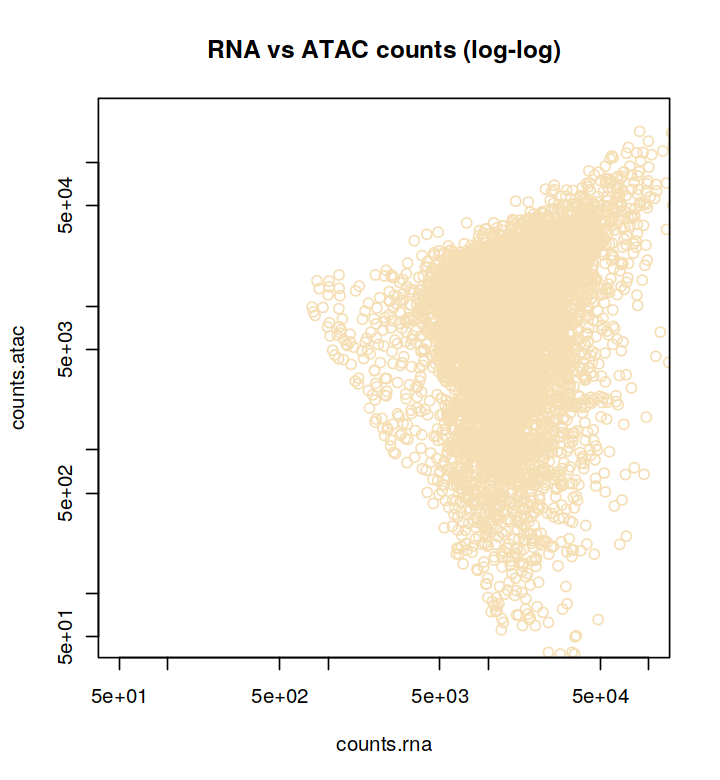

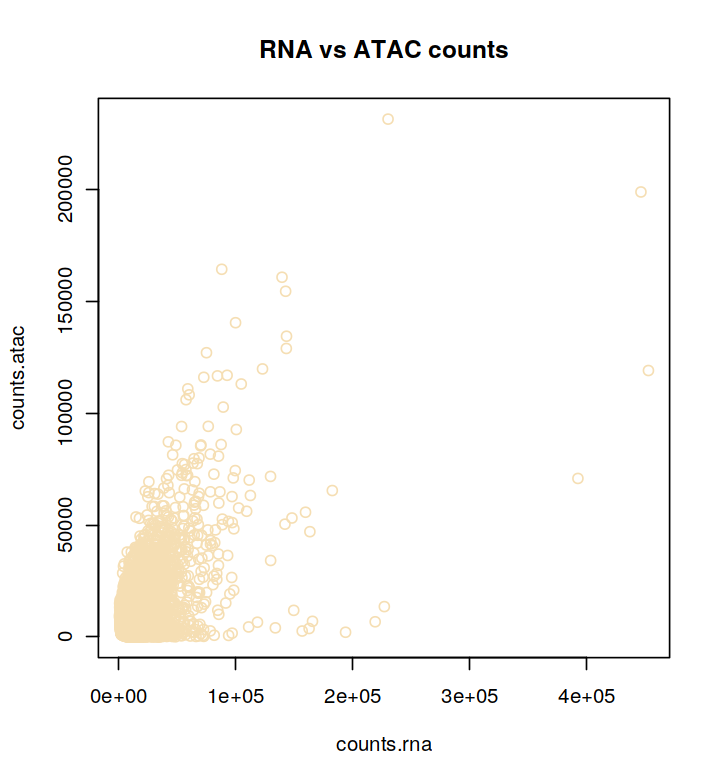

In [25]:
options(repr.plot.width=6, repr.plot.height=6.5)
#par(mfrow=c(1,2))
plot(counts.rna, counts.atac, log='xy', col='wheat', xlim=c(50,100000), ylim=c(50,200000))
title('RNA vs ATAC counts (log-log)')
plot(counts.rna, counts.atac, col='wheat')
title('RNA vs ATAC counts')

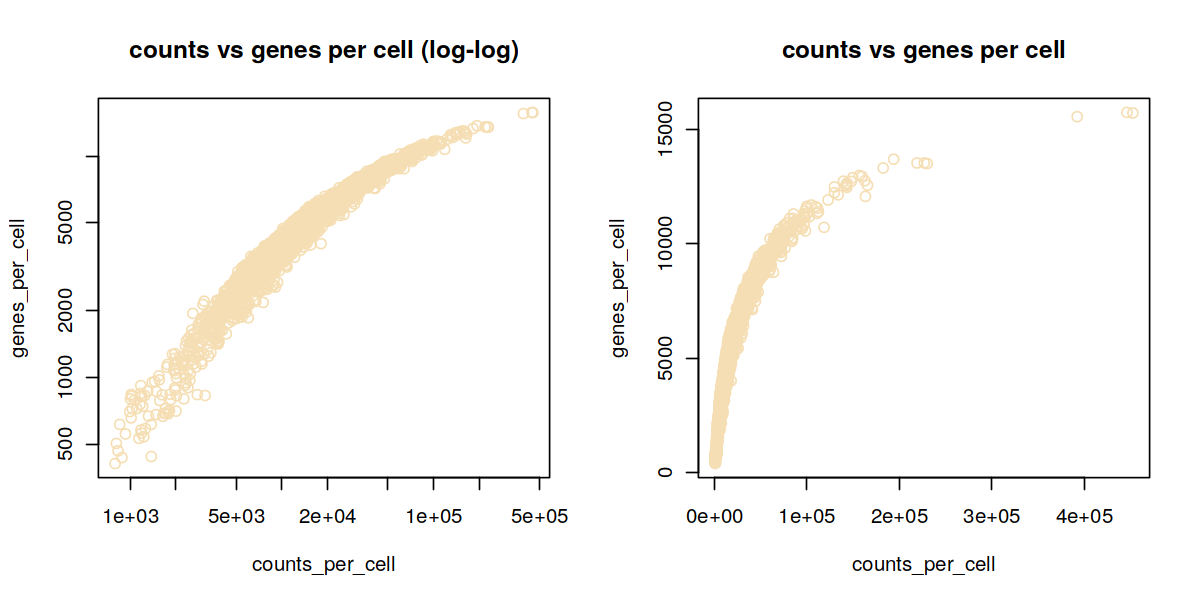

In [26]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
plot(counts_per_cell, genes_per_cell, log='xy', col='wheat')
title('counts vs genes per cell (log-log)')
plot(counts_per_cell, genes_per_cell, col='wheat')
title('counts vs genes per cell')

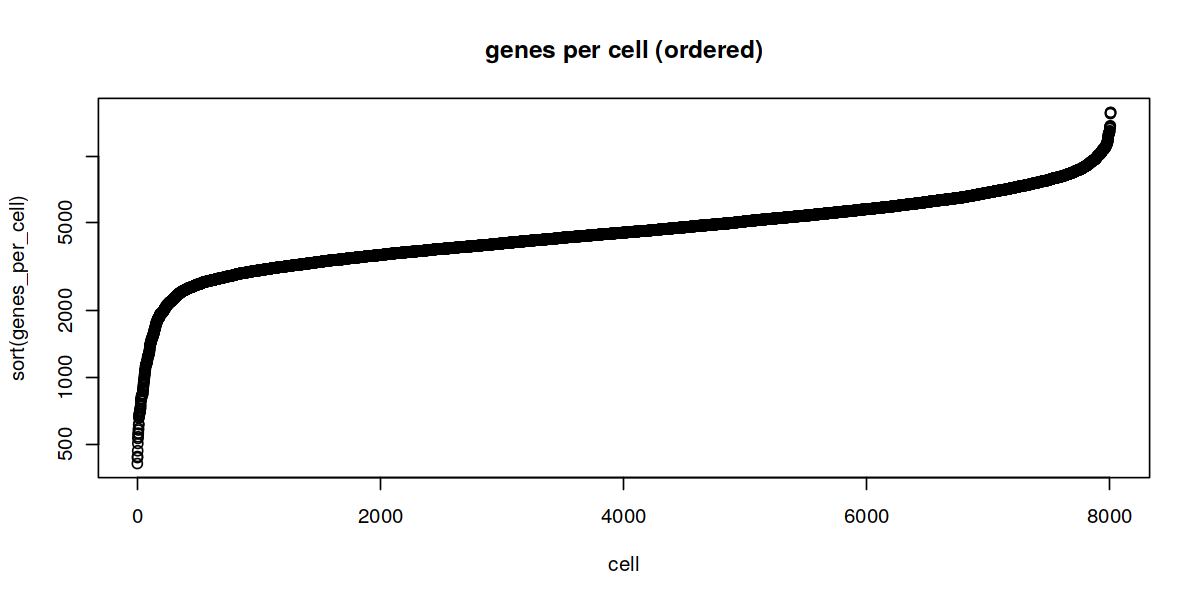

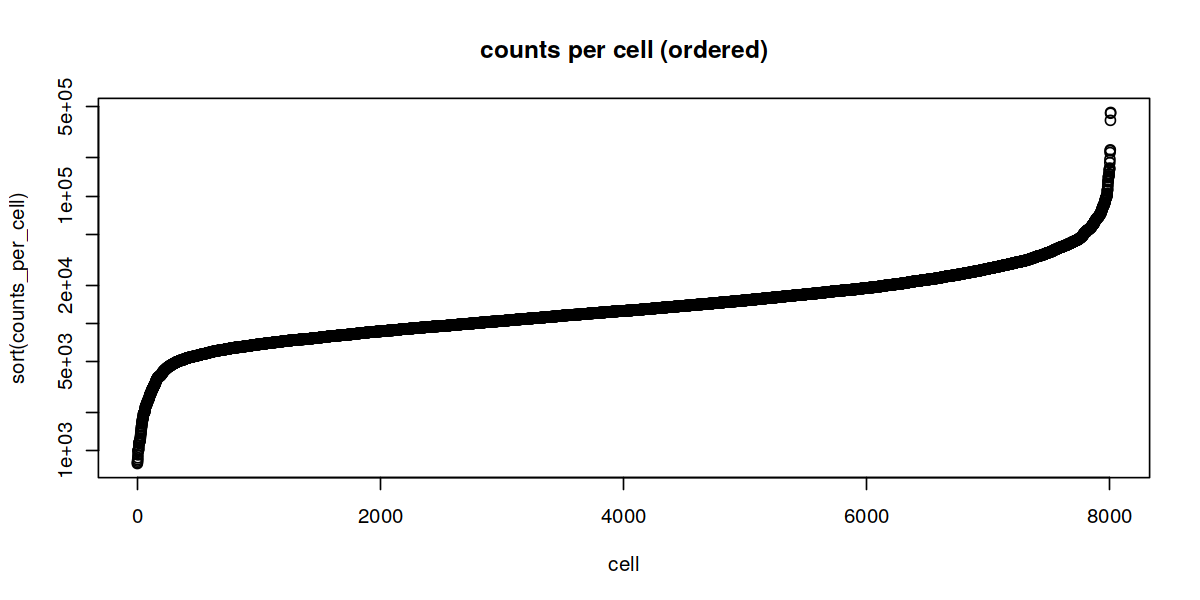

In [27]:
plot(sort(genes_per_cell), xlab='cell', log='y', main='genes per cell (ordered)')
plot(sort(counts_per_cell), xlab='cell', log='y', main='counts per cell (ordered)')

In [28]:
#FeatureScatter(object = seurat, feature1 = "nCount_RNA", feature2 = "nCount_ATAC", log)

### QC using houskeeping genes

In [29]:
# Load the the list of house keeping geneshkgenes <- read.table('{PATH_TO_HOUSEKEEPING_TXT}', skip = 2)hkgenes <- as.vector(hkgenes$V1)

In [30]:
# remove hkgenes that were not found
hkgenes.found <- which(toupper(rownames(seurat@assays$RNA@data)) %in% hkgenes)

In [31]:
num_hk_genes = length(hkgenes.found)
num_hk_genes

[1] 95

In [32]:
n.expressed.hkgenes <- Matrix::colSums(seurat@assays$RNA@data[hkgenes.found, ] > 0)

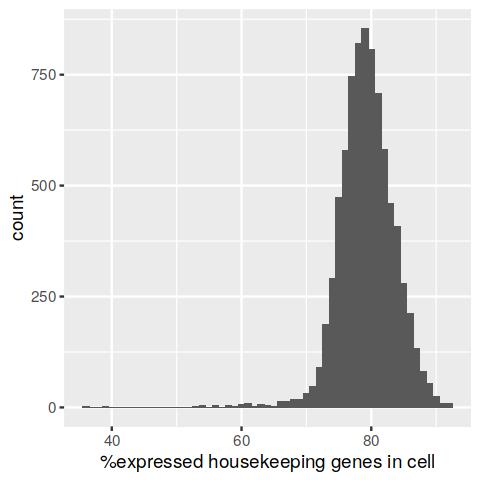

In [33]:
options(repr.plot.width=4, repr.plot.height=4)
df.expressed.hk <- data.frame(100*n.expressed.hkgenes/num_hk_genes)
ggplot(df.expressed.hk, aes(n.expressed.hkgenes)) + geom_histogram(binwidth=1) + labs(x="%expressed housekeeping genes in cell")

### QC by mitochondrial genes

Warning message:
"Removed 784 rows containing missing values (`geom_point()`)."


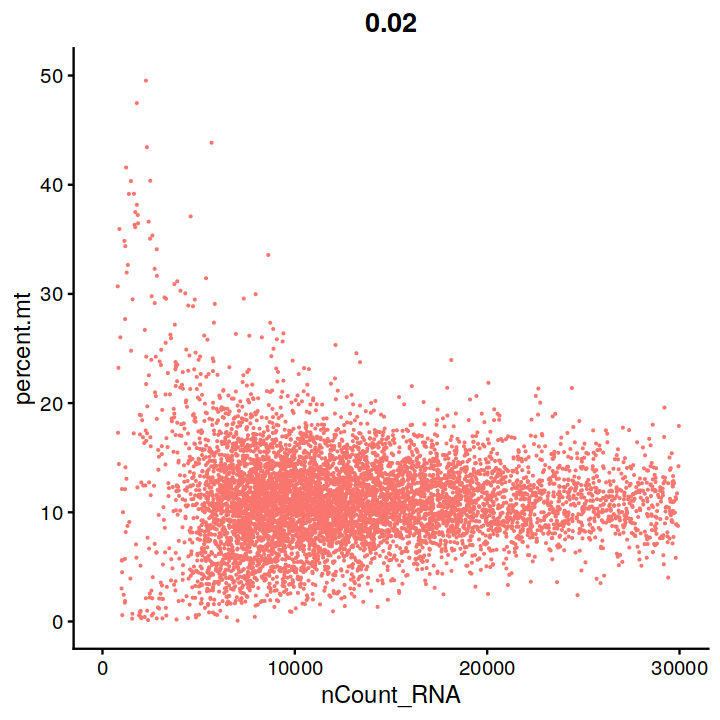

In [34]:
options(repr.plot.width=6, repr.plot.height=6)
plot1 <- FeatureScatter(seurat, feature1 = "nCount_RNA", feature2 = "percent.mt", pt.size=.1)
plot1 + xlim(c(0,30000)) + ylim(c(0,50)) + NoLegend()

## More ATAC QC

In [35]:
DefaultAssay(seurat) <- "ATAC"
seurat <- NucleosomeSignal(seurat)
seurat <- TSSEnrichment(seurat)

Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



Peak region fragments is not in the object. Find out why.

In [49]:
# add blacklist ratio and fraction of reads in peaks
# seurat$pct_reads_in_peaks <- seurat$peak_region_fragments / seurat$passed_filters * 100
#seurat$blacklist_ratio <- seurat$blacklist_region_fragments / seurat$peak_region_fragments

ERROR: Error: Cannot find 'peak_region_fragments' in this Seurat object


In [37]:
df.nucleosome.signal <- data.frame(seurat@meta.data$nucleosome_signal)
df.tss.enrichment    <- data.frame(seurat@meta.data$TSS.enrichment)

Warning message:
"Removed 30 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


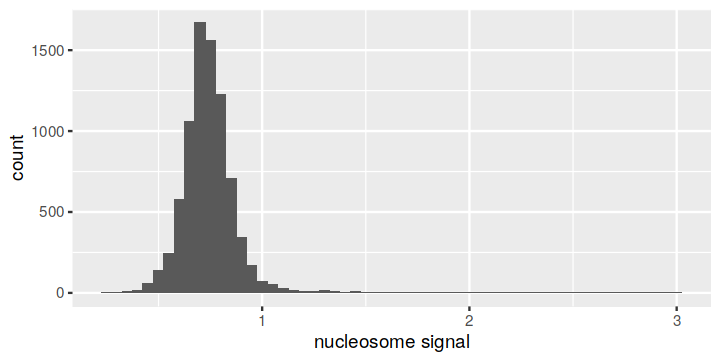

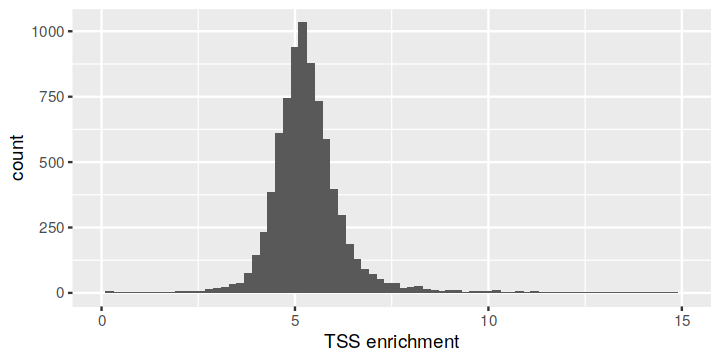

In [38]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(df.nucleosome.signal, aes(seurat.meta.data.nucleosome_signal)) +
    geom_histogram(binwidth=.05) +
    labs(x="nucleosome signal")

ggplot(df.tss.enrichment, aes(seurat.meta.data.TSS.enrichment)) +
    geom_histogram(binwidth=.2) +
    labs(x="TSS enrichment") +
    xlim(0,15)

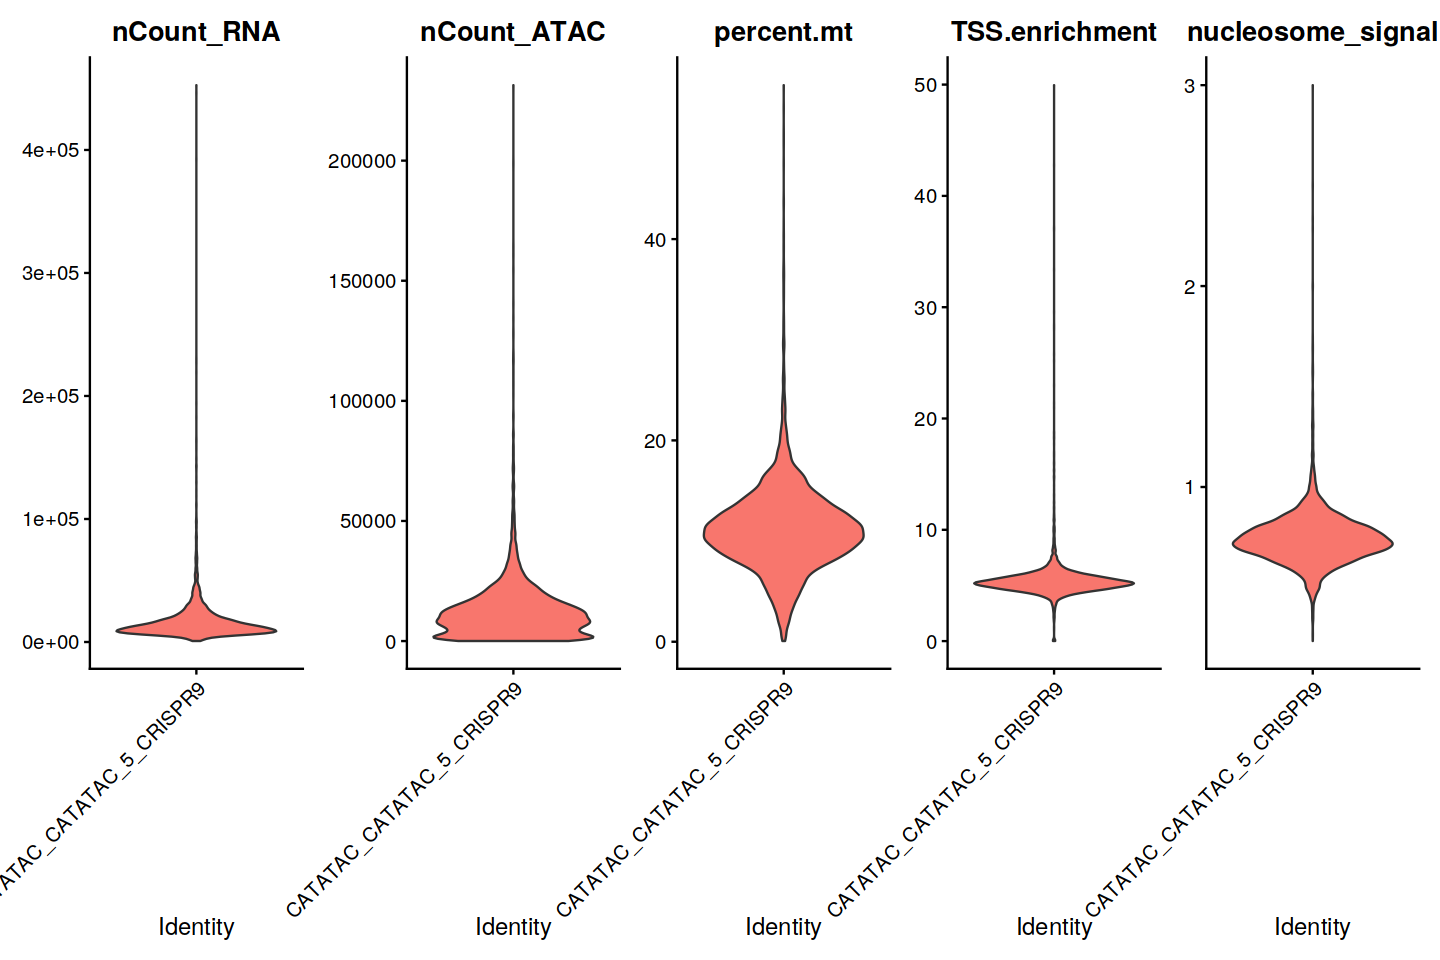

In [39]:
options(repr.plot.width=12, repr.plot.height=8)

VlnPlot(
  object = seurat,
  features = c("nCount_RNA", "nCount_ATAC", "percent.mt", "TSS.enrichment", "nucleosome_signal"),
  ncol = 5,
  pt.size = 0
)

## Filter out low quality cells

In [40]:
seurat <- subset(
  x = seurat,
  subset = nCount_ATAC < 6e4 &
    nCount_ATAC > 1000 &
    nCount_RNA < 40000 &
    nCount_RNA > 1000 &
    percent.mt < 40 &       #change to 40
    nucleosome_signal < 2 &
    TSS.enrichment > 1
)


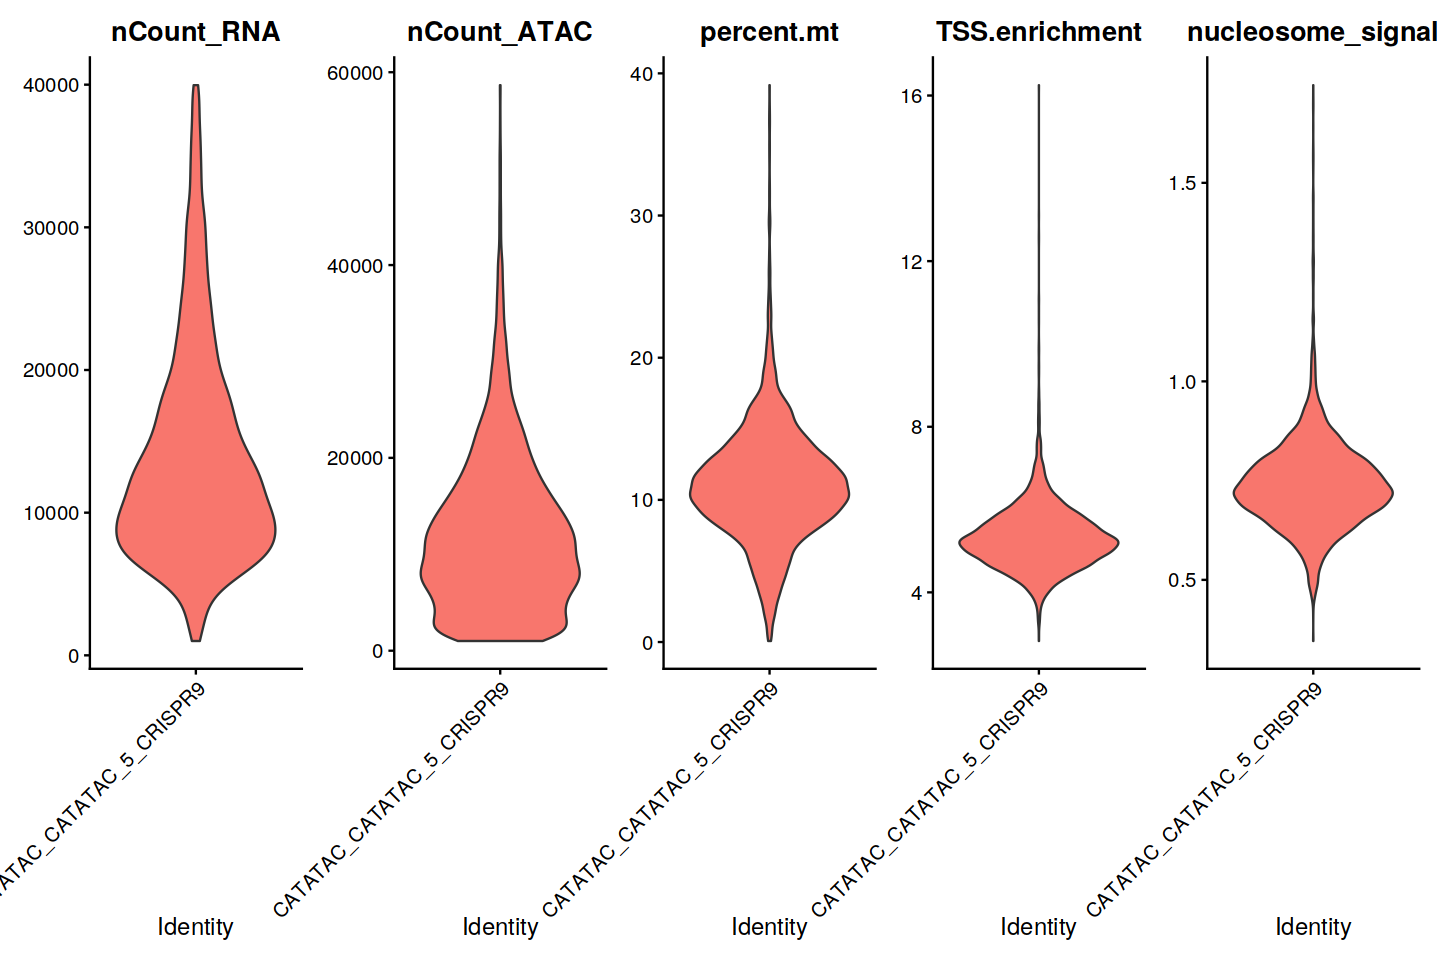

In [41]:
options(repr.plot.width=12, repr.plot.height=8)

VlnPlot(
  object = seurat,
  features = c("nCount_RNA", "nCount_ATAC", "percent.mt", "TSS.enrichment", "nucleosome_signal"),
  ncol = 5,
  pt.size = 0
)

In [42]:
n_filtered_cells = length(Cells(seurat))
frac_filtered = (n_init_cell_count - n_filtered_cells) / n_filtered_cells
cat("Frac filtered doublets:", frac_filtered)

Frac filtered doublets: 0.146785

## Normalization, PCA, UMAP, SVD

In [43]:
DefaultAssay(seurat) <- "RNA"
seurat <- SCTransform(seurat, verbose = FALSE) %>% 
          RunPCA() %>% 
          RunUMAP(dims = 1:50, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_')

PC_ 1 
Positive:  FN1, HAS2, SLIT3, PCDH7, TFPI, RCN3, AC068587.4, BAMBI, LHX1, MEIS2 
	   CTNNA2, LRP1B, ZFPM2, LAPTM4B, NKX2-5, FOXP2, ROBO2, BMP4, IFI16, DGKB 
	   MECOM, KIF26B, GRIK2, FAM184A, NRP1, KRT18, PCAT14, HAPLN1, GATA5, S100A11 
Negative:  PTPRZ1, PTN, L1TD1, GRID2, RPLP1, RPL41, SFRP1, HSP90AB1, RPS8, HMGB1 
	   SFRP2, HSP90AA1, POLR3G, RPS2, BCAT1, POU5F1, TMEM132B, NES, NASP, PTMA 
	   FGFBP3, RPL13, RPS15, RPS6, NPM1, RPS23, RPS18, VIM, RPS3, CDH6 
PC_ 2 
Positive:  DCC, EBF2, STMN2, IGFBPL1, TUBB3, DLL3, MALAT1, ADARB2, MAP2, KCNIP4 
	   ELAVL3, SRRM4, NAV2, SYT1, EBF1, ST18, CACNA2D1, DCX, NEUROG2, NOVA1 
	   CADPS, EFNA5, MAP1B, ADGRL3, RUNX1T1, EBF3, NCAM1, KALRN, NRXN1, THSD7A 
Negative:  FN1, KRT18, HAS2, TPM1, RCN3, BAMBI, NKX2-5, PTMA, SLIT3, LAPTM4B 
	   ID3, FST, PCAT14, APOE, HSP90AB1, HMGB1, BMP4, RPL41, MYL7, KRT8 
	   S100A11, ID1, MT-ND1, RPLP1, MT-ND2, PCDH7, MT-ND4, HSP90AA1, ACTB, RPS8 
PC_ 3 
Positive:  L1TD1, GRID2, PCAT14, PCDH11X, PTPRZ1, POU5F1,

# Mark doublets

Skipping this step. Scrublet detects only a few doublets. Also m3addon won't load on Angela's Jupyter account.

In [44]:
#cds = as.cell_data_set(seurat)

In [45]:
# cds    <- my_scrublet_R(
#             cds, 
#             n_prin_comps = 30,
#             return_results_only = FALSE,
#             min_counts=2, 
#             min_cells=3, 
#             min_gene_variability_pctl=85
#         )

### Assigning fake doublet scores, so that the rest of the pipeline won't fail. 

In [46]:
seurat$predicted_doublets = FALSE
seurat$doublet_scores = 0

In [47]:
#seurat_w_doublet_scores <- append_doublet_results(cds, seurat)
SaveH5Seurat(seurat, h5_name, overwrite = TRUE, verbose = FALSE)

Warning message:
"Overwriting previous file /home/jupyter-ayang/notebooks/cat-atac_pipeline/cond9/secondary/output/seurat/CATATAC_5_CRISPR9.h5seurat"
Creating h5Seurat file for version 3.1.5.9900



In [48]:
#table(seurat_w_doublet_scores$predicted_doublets)